# Tutorial on how to fit emission line and use IFU data - KMOS/SINFONI/JWST etc

Here I am going to go through basic of analysing IFU data and fitting emission lines. First, in order to quickly look at IFU cubes, I recommend QFits. https://www.mpe.mpg.de/~ott/QFitsView/. 

To read more about Integral Field Spectroscopy, I recommend section 2.2 of my thesis: http://etheses.dur.ac.uk/13311/1/Thesis_cor_mk_II.pdf?DDD25+ or from Chris Harrison; Chapter 2. http://etheses.dur.ac.uk/10744/1/cmh_thesis.pdf?DDD25+


# Dealing wih IFU data

We will first start with loading the cube and extracting a spectrum. We will then continue to write a simple fitting code to fit the spectrum from the previous tutorial. 

Lets start with importing basic libraries. This is a start of every code I write. 

In [1]:
#importing modules
import numpy as np
import matplotlib.pyplot as plt; plt.ioff()

from astropy.io import fits as pyfits
from astropy import wcs
from astropy.table import Table, join, vstack
from matplotlib.backends.backend_pdf import PdfPages
import pickle
from scipy.optimize import curve_fit

import emcee
import corner 

from os.path import exists
nan= float('nan')

pi= np.pi
e= np.e

plt.close('all')
c= 3.*10**8
h= 6.62*10**-34
k= 1.38*10**-23



PATH='/Users/jansen/My Drive/Astro/'


## Loading the JWST IFS cube. 

We will now load the IFU cube and extract all of the import information. We need to extract the wavelength grid and the data cube and the header information. 

In [8]:
path = '/Users/jansen/JADES/GA_NIFS/IFS_data_v1/' 
file_name = '5001-GS-3.47-S_jw1216_o005_ff_px0.05_drizzle_ODfde98_3_VSC_MRC_MSA_m2ff_CTX1068.pmap_v1.8.2_g235h-f170lp_cgs_s3d.fits' # Full path to the file

Full_path = path + file_name

with pyfits.open(Full_path, memmap=False) as hdulist:

    Flux_cube = hdulist['SCI'].data *1e4 * 1e15
    Header = hdulist['SCI'].header

    n_channels = Header['NAXIS3'] # Extract the number pixels in the third axis (wavelength)
    obs_wave = Header['CRVAL3'] + (np.arange(n_channels) - (Header['CRPIX3'] - 1.0))*Header['CDELT3'] # Extract the wavelength grid


z = 3.471

plt.show()


## Extracting a spectrum from multiple spaxel together - circular aperture 

The best thing about IFS is that we extract spectrum from anywhere in the galaxy to investigate the properties in that section. We can use a very simple circular mask to setup to create a spectrum with a sum of all of the spaxels. 

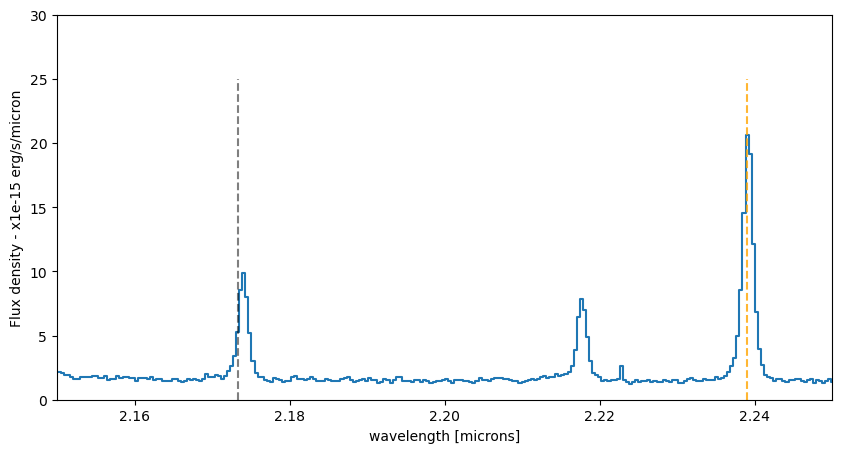

In [9]:
def sp_circ_ap(cenx,ceny,rad,Flux_cube):

    nwl = len(Flux_cube[:,0,0])
    nx = len(Flux_cube[0,0,:])
    ny = len(Flux_cube[0,:,0])
    # creates array with one spectrum per row
    intermarray = np.full((nwl,nx*ny), np.nan)
    # fills it with nans
    
    nloop = 0
    # loop on data
    for x in range(nx) :
        for y in range(ny) :  
            distance = np.sqrt((x-cenx)**2+(y-ceny)**2)
            if distance < rad :
                intermarray[:,int(nloop)] = Flux_cube[:,int(y),int(x)]
                nloop += 1
               
    # average
    outspec = np.nansum(intermarray,axis=1)
    return outspec

# This function extracts the spectrum from a circular aperture of radius 5 pixels centered on the sp
D1_spec = sp_circ_ap(44,47,5,Flux_cube) # 5 pixel radius aperture centered on the spaxel at (44,47)

D1_spec = np.ma.masked_invalid(D1_spec ) # Mask invalid values (nans, infs etc.)

f, ax = plt.subplots(1, 1, figsize=(10, 5))

x,y  = 44,47 # Coordinates of the spaxel we want to extract the spectrum from
ax.plot( obs_wave, D1_spec, drawstyle='steps-mid')
ax.set_xlabel('wavelength [microns]')
ax.set_ylabel('Flux density - x1e-15 erg/s/micron')

ylow = -0.0
yhig = 25

ax.vlines(0.5008*(1+z),ylow,yhig, linestyle='dashed',color='orange', alpha=0.8)
ax.vlines(0.6300*(1+z),ylow,yhig, linestyle='dashed',color='orange', alpha=0.8)

ax.vlines(0.6563*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)
ax.vlines(0.4861*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)

ax.vlines(0.6731*(1+z),ylow,yhig, linestyle='dashed',color='k', alpha=0.5)

ax.set_xlim(2.15,2.25)
ax.set_ylim(-0.,30.)

plt.show()

## Fitting the spectrum 

Please fit the spectrum of the [OIII] using the methods we have used in previous section to 

In [ ]:
# Fit the OIII and Hbeta lines of our the combined spectrum. 

# Fitting multi components to the [OIII]

We will now focus on fitting multiple kinematical components to one emission line. First we will fit emission the single compoennt like above and the also one where we fit additional Gaussian component to each emission line with tied redshift/velocity offset and FWHM of this new component. 

In [ ]:
# Defining the model for fitting emission lines around Halpha including of course Halpha itself. 
# Setting up a single Gaussian - will be used later 
def gauss(x, k, mu,FWHM):
    sig = FWHM/2.35482/3e5*mu
    expo= -((x-mu)**2)/(2*sig*sig) 
    y= k* e**expo
    return y

# Setting up the Halpha model:
# First we calculate the observed frame wavelengths of the lines
# Then we calculate the individfual components - Halpha, [NII] and [SII]
# Finally we add all of them together
def OIII_Hbeta(x, z, cont,cont_grad,  OIII_peak, Hbeta_peak, Nar_fwhm):
    OIIIr_wv = 5008.24*(1+z)/1e4    
    OIIIb_wv = 4960.*(1+z)/1e4
    Hbeta_wv = 4862.6*(1+z)/1e4
    
    OIII_nar = gauss(x, OIII_peak, OIIIr_wv, Nar_fwhm) + gauss(x, OIII_peak/2.99, OIIIb_wv, Nar_fwhm)

    Hbeta_nar = gauss(x, Hbeta_peak, Hbeta_wv, Nar_fwhm)
    continuum = cont+x*cont_grad

    return continuum+ OIII_nar + Hbeta_nar

def OIII_Hbeta_outflow(x, z, cont,cont_grad,  OIII_peak, Hbeta_peak, Nar_fwhm, OIII_out_peak, Hbeta_out_peak, outflow_fwhm, outflow_vel):
    OIIIr_wv = 5008.24*(1+z)/1e4    
    OIIIb_wv = 4960.*(1+z)/1e4
    Hbeta_wv = 4862.6*(1+z)/1e4
    
    Narrow = gauss(x, OIII_peak, OIIIr_wv, Nar_fwhm) + gauss(x, OIII_peak/2.99, OIIIb_wv, Nar_fwhm)+\
        gauss(x, Hbeta_peak, Hbeta_wv, Nar_fwhm)

    continuum = cont+x*cont_grad

    OIIIr_wv_broad = 5008.24*(1+z)/1e4  + outflow_vel_in_wavelength
    OIIIb_wv_broad = 4960.*(1+z)/1e4  + outflow_vel_in_wavelength
    Hbeta_wv_broad = 4862.6*(1+z)/1e4  + outflow_vel_in_wavelength

    Broad = 

    return continuum + Narrow + Broad

### What is the better model for our data?

Fit the emission line using the leastsq like above using the outflow model. We can now start comparing the model best fits and see what is the best model for the data. There are many different ways to do this. We can calculate:

1. Chi2 or reduced chi2 and see what is lower value -

\begin{equation}
 \chi^{2}=  \frac{ (data-model)^2}{ error^2 } 
\end{equation}

\begin{equation}
 reduced chi^{2}=  \frac{1}{n-m}\frac{ (data-model)^2}{ error^2 } 
\end{equation}

where n is the number of data points we are fitting and the m is the number of parameters in our model. 

2. BIC: 

\begin{equation}
 BIC = \chi^{2} + n \times ln(m)
\end{equation}

We can then select things we lowest $\chi^2$ reduced $\chi^2$ or BIC. That we can see if we have a good enough fit with a single component fit or we need something more complex. 

In [ ]:
# Estimate the chi2, reduced chi2 and BIC and pick the best model. 